# Sentiment Classification

In this notebook, we will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

we use movie_reviews from nltk for the purpose.



In [88]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [90]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [91]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])
#print(training_data.categories())

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['matthew', 'broderick', 'and', 'high', 'school', ...], 'pos')


Currently,we have training data and testing data generated from the above code.

In [92]:
#preprocessing step : convert to lower(already lowered),remove stop words. 
stop_words = stopwords.words('english')
def normalise(wordlist):
    lowered=[word.lower() for word in wordlist] #don't actually need this as already lowered
    filtered_words=[word for word in lowered if word.isalpha() and word not in stop_words]
    return filtered_words

In [93]:
#normalise the training and testing data and obtain frequency distribution of both
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data] 

In [94]:
#create frequency distribution of negative and positive words separately

positive_freq_dist=FreqDist()
negative_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
       positive_freq_dist+=reviewDist
    if label=='neg':
       negative_freq_dist+=reviewDist

#1a. List of 10 postive words      

positive_words=positive_freq_dist-negative_freq_dist  #compute difference of positive and negative words
most_used_positive=positive_words.most_common()
positive_words_only=[word for (word,freq) in most_used_positive[:10]]
print("Q1 : List of  10 positive words : \n",positive_words_only)

Q1 : List of  10 positive words : 
 ['film', 'life', 'also', 'great', 'best', 'world', 'story', 'well', 'many', 'one']


In [95]:
#1b.List of 10 negative words

negative_words=negative_freq_dist-positive_freq_dist #compute difference of negative and positive words
most_used_neg=negative_words.most_common()
negative_words_only=[word for (word,freq) in most_used_neg[:10]]
print("Q2 : List of  10 Negative words : \n",negative_words_only)

Q2 : List of  10 Negative words : 
 ['movie', 'bad', 'plot', 'worst', 'script', 'boring', 'nothing', 'stupid', 'could', 'supposed']


In [96]:
#   Q2: word list classifier to classify reviews positive or negative

from nltk.classify.api import ClassifierI
import random

class MovieClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 
         

    def classify(self, doc): 
        #doc is a FreqDist
        sc = 0
        
        #assigning appropriate values to sc
        for word,value in doc.items():
            if word in self._pos:
                sc+=value
            if word in self._neg:
                sc-=value
        
        if sc < 0 :
            return "neg"
        elif sc > 0:
            return "pos"
        else:
            return random.choice(movie_reviews.categories()) 

    def classify_many(self, docs): 
        return [self.classify(doc) for doc in docs]   

    def labels(self): 
        return ("pos", "neg")


classifier = MovieClassifier(positive_words_only, negative_words_only)
classifier.classify(FreqDist(" the movies was bad".split()))

'neg'

In [97]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    accu = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            accu+=1
    
    return accu / (len(test_data))

In [98]:
#       Q3a.Calculate Accuracy of wordlist classifier

my_pos = positive_words_only
my_neg = negative_words_only
MovieClassifier1=MovieClassifier(my_pos,my_neg)
#Evaluate on Testing data
accu_test=classifier_evaluate(MovieClassifier1,testing_norm)

In [99]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        #self.predictions=predictions
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    #calculate prescion
    def precision(self):
        p=0

        p = self.TP / (self.TP + self.FP)
    
        return p
    #calculate recall
    def recall(self):
        r=0
        
        r = self.TP / (self.TP + self.FN)
        return r
    #calculate f1
    def f1(self):
        f1=0
        p=self.precision()
        r=self.recall()
        f1= (2*p*r)/(p+r)
        return f1

In [100]:
#FIND the TN,FN,TP,FP for testing_data
docs,labels=zip(*testing_norm) 

senti_cm=ConfusionMatrix(MovieClassifier1.classify_many(docs),labels)
print(senti_cm.TP)
print(senti_cm.FP)
print(senti_cm.TN)
print(senti_cm.FN)

278
228
72
22


In [101]:
# calculating prescion,recall,f1 for testinging set
print("testing_data")
pw=senti_cm.precision()
rw=senti_cm.recall()
f1w=senti_cm.f1()
print("Accuracy : ",accu_test)
print("prescion : ",pw)
print("Recall   : ",rw)
print("F1 Score : ",f1w)

testing_data
Accuracy :  0.5816666666666667
prescion :  0.549407114624506
Recall   :  0.9266666666666666
F1 Score :  0.6898263027295286


In [102]:
#     4a. Naive Bayes Classifier
from nltk.classify import NaiveBayesClassifier #importing the NaiveBayesClassifier from nltk

In [103]:
naive_bayes=NaiveBayesClassifier.train(training_norm)

In [104]:
nbc=naive_bayes.classify_many(docs) #testing_data accessed from variable docs

In [105]:
#compute prescion,recall and f1 of Naive-Bayes Classifier

cm1=ConfusionMatrix(nbc,labels,classes=("pos","neg"))
anbc=classifier_evaluate(naive_bayes,testing_norm)
pnbc=cm1.precision()
rnbc=cm1.recall()
f1nbc=cm1.f1()
print("Recall:\t\t",rnbc)
print("Precision:\t",pnbc)
print("F1:\t\t",f1nbc)
print("Accuracy:\t",anbc)

Recall:		 0.9933333333333333
Precision:	 0.5831702544031311
F1:		 0.7348951911220715
Accuracy:	 0.6416666666666667


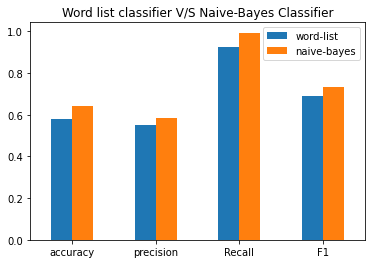

In [106]:
#4b. comaparison of naive-bayes and word list classifier
word_classifier=[accu_test,pw,rw,f1w]
nb_classifier=[anbc,pnbc,rnbc,f1nbc]
index = ['accuracy', 'precision','Recall','F1']
df = pd.DataFrame({'word-list': word_classifier,
                   'naive-bayes': nb_classifier}, index=index)

ax = df.plot.bar(title="Word list classifier V/S Naive-Bayes Classifier",rot=0)



As we can see from the plot,all the parameters of measurements are higher for Naive-Bayes classifier.Since accuracy and precision is high we can easily identify both true positives and true negatives.Hence Naive Bayes can be recommended for systems where false positives dont have huge cost due to its high prescion.In the question we are working on a binary classification.Hence selecting any of the two is optionable however it is preferable to go with Naivebayes classifier due to its high speed and accuracy.Naive Bayes classifier assumes that the impact of a particular feature is independent of other faetures.

 an experiment into the impact of the **length of the wordlists** on the wordlist classifier.  






In [107]:
#find postive and negative words : function
def most_frequent_words(posfreq,negfreq,topk):
    difference=posfreq-negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

In [108]:
class MovieClassifier_inher(MovieClassifier):
    
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):
        
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist
                
        self._pos=most_frequent_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=most_frequent_words(neg_freq_dist,pos_freq_dist,self._k)
    


Let us now consider a list of multiple numbers where each number is a wordlist size.Find the Accuracy for each word list size and append the same into a list.Now create a dataframe of accuracies and plot a graph of the same.

,Accuracy
10,0.585000
20,0.591667
30,0.595000
40,0.581667
50,0.568333
60,0.568333
70,0.566667
80,0.568333
90,0.578333
100,0.590000


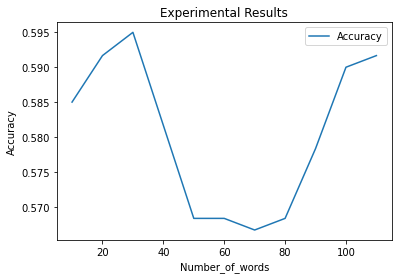

In [109]:
from random import sample
number_of_wordlist=[10,20,30,40,50,60,70,80,90,100,110]
accuracies=[]
for size in number_of_wordlist:
    classifier_n = MovieClassifier_inher(size)
    classifier_n.train(training_norm)
    accuracy_2=classifier_evaluate(classifier_n,testing_norm)
    accuracies.append(accuracy_2)

df = pd.DataFrame({
   'Accuracy': accuracies
   }, index=number_of_wordlist)
ax = df.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number_of_words")
df

After running the code and obtaining the line graph,it is clearly visible that accuracy of the classifier peaks around 20-30 word size.It then gradually decreases and keep reaches a minimum at 80 word size. visible that it then gradually decreases.It is also necessary to note that the peak vale of accuracy always stay around 0.59(20,100,110)
In the next step let us take an average of 3 runs and check if pattern is still the same.

In [110]:
number_of_runs=3
accuracies=[0]*len(number_of_wordlist)
for i in range(0,len(number_of_wordlist)):
    
    for run in range(0,number_of_runs):
        classifier_m = MovieClassifier_inher(number_of_wordlist[i])
        classifier_m.train(training_norm)
        #results=classifier.classify_many(doc for (doc,label) in testing_norm)
        # Testing the precision recall and f1 score of our model
        #docs,labels=zip(*testing_data)
        #senti_cm=ConfusionMatrix(results,labels)
        accuracy2=classifier_evaluate(classifier_m,testing_norm)
    #     print(accuracy2)
        accuracies[i]+=(accuracy2/number_of_runs)
        print(accuracies[i])
        print(i)

0.1938888888888889
0
0.3883333333333333
0
0.5833333333333333
0
0.19666666666666666
1
0.3911111111111111
1
0.5905555555555555
1
0.1977777777777778
2
0.39611111111111114
2
0.5911111111111111
2
0.1938888888888889
3
0.38611111111111107
3
0.5805555555555555
3
0.1922222222222222
4
0.3822222222222222
4
0.5738888888888889
4
0.1922222222222222
5
0.3827777777777778
5
0.5733333333333334
5
0.18833333333333332
6
0.37666666666666665
6
0.5644444444444444
6
0.18944444444444444
7
0.3794444444444444
7
0.5683333333333334
7
0.1927777777777778
8
0.3861111111111111
8
0.5788888888888889
8
0.19666666666666666
9
0.3933333333333333
9
0.5911111111111111
9
0.19666666666666666
10
0.39388888888888884
10
0.591111111111111
10


,Accuracy
10,0.584444
20,0.595556
30,0.591111
40,0.582222
50,0.575000
60,0.572222
70,0.564444
80,0.570000
90,0.577778
100,0.590556


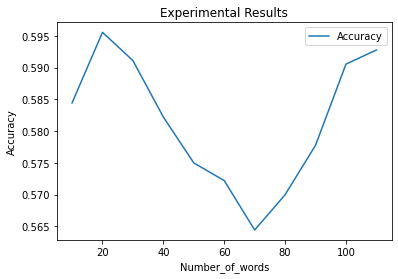

In [86]:
df = pd.DataFrame({
   'Accuracy': accuracies
   }, index=number_of_wordlist)
ax = df.plot(kind="line",title="Experimental Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number_of_words")
df

From the plot obtained,we can certain the same behavior even when we take an average of 3 runs. Hence we can conclude that the classifier gives highest accuracy when the word list is between 20 to 30. It then fluctates and decreases as the word size increases.
Based on the experiment we can conclude that size of word list has a significant impact on the wordlist classifier regardless of the number of times it is run.